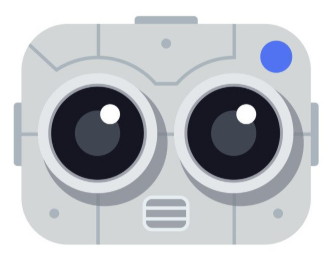

<h1><center>DETECTRON 2 COMPARE MODELS</h1>
    
***

<h1>Introduction</h1>

<p style="text-align:justify;">This competition wants us to predict bounding boxes around whaet heads from images of wheat plants, to solve this problom we have a sample of image, and csv file containing the image_id (the unique image ID), the width and height of the images, and bounding box, formatted as a Python-style list of [xmin, ymin, width, height]</p>

***

Hello, this is my second notebook in this competition, if you want to see my other notebook, [Global Wheat Detection FASTER R-CNN [EDA - AUGMENTATION - COMPARE MODELS]](https://www.kaggle.com/dhiiyaur/fasterrcnn-eda-augmentation-compare-models). The main idea of this notebook its to compare models in detectron 2 with this dataset ( test with Nvidia T4).


## Changelog

### V1

> - add new model
> - add augmentation

## Import necessary libraries

In [ ]:
!pip install '/kaggle/input/torch-15/yacs-0.1.7-py3-none-any.whl'
!pip install '/kaggle/input/torch-15/fvcore-0.1.1.post200513-py3-none-any.whl'
!pip install '/kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl'
!pip install '/kaggle/input/detectron2/detectron2-0.1.3cu101-cp37-cp37m-linux_x86_64.whl'

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import random

import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
%matplotlib inline

import cv2
import itertools
import copy


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

In [ ]:
DATA_DIR  = '/kaggle/input/global-wheat-detection/train/'
TEST_DIR  = '/kaggle/input/global-wheat-detection/test/'
List_Data_dir = os.listdir(DATA_DIR)

### Config

In [ ]:
# for example model

MODEL_USE = 3

if MODEL_USE == 1:
    MODEL = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
    WEIGHT_PATH = '../input/global-wheat-detection-model/Detectron_2/faster_rcnn_R_50_FPN_3x.pth'
elif MODEL_USE == 2:
    MODEL = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
    WEIGHT_PATH = '../input/global-wheat-detection-model/Detectron_2_v2/R-50_5k_augmen.pth'
elif MODEL_USE == 3:
    MODEL = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
    WEIGHT_PATH = '../input/global-wheat-detection-model/Detectron_2_v2/R-50_10k_augmen.pth'
    
MAX_ITER = 5000 #10000

## Load Data and Simple EDA

In [ ]:
raw = pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')
raw

In [ ]:
print(f'Total number of train images: {raw.image_id.nunique()}')
print(f'Total number of test images: {len(os.listdir(TEST_DIR))}')

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Wheat Distribution', fontsize= 20)
sns.countplot(x="source", data=raw)

# based on the chart, there are seven types of wheat from images data, with the most types 'ethz_1' and the least is 'inrae_1'

In [ ]:
# Extract bbox column to xmin, ymin, width, height, then create xmax, ymax, and area columns

raw[['xmin','ymin','w','h']] = pd.DataFrame(raw.bbox.str.strip('[]').str.split(',').tolist()).astype(float)
raw['xmax'], raw['ymax'], raw['area'] = raw['xmin'] + raw['w'], raw['ymin'] + raw['h'], raw['w'] * raw['h']
raw

In [ ]:
def show_image(image_id):
    
    fig, ax = plt.subplots(1, 2, figsize = (24, 24))
    ax = ax.flatten()
    
    bbox = raw[raw['image_id'] == image_id ]
    img_path = os.path.join(DATA_DIR, image_id + '.jpg')
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['source']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,255,255), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,255,255), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

In [ ]:
show_image(raw.image_id.unique()[1111])

## Data Preprocessing

In [ ]:
# split train, val
unique_files = raw.image_id.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.90), replace = False))
train_df = raw[raw.image_id.isin(train_files)]
test_df = raw[~raw.image_id.isin(train_files)]

In [ ]:
print(len(train_df.image_id.unique()), len(test_df.image_id.unique()))

In [ ]:
def custom_dataset(df, dir_image):
    
    dataset_dicts = []
    
    for img_id, img_name in enumerate(df.image_id.unique()):
        
        record = {}
        image_df = df[df['image_id'] == img_name]
        img_path = dir_image + img_name + '.jpg'
        
        record['file_name'] = img_path
        record['image_id'] = img_id
        record['height'] = int(image_df['height'].values[0])
        record['width'] = int(image_df['width'].values[0])
                
        objs = []
        for _, row in image_df.iterrows():
            
            x_min = int(row.xmin)
            y_min = int(row.ymin)
            x_max = int(row.xmax)
            y_max = int(row.ymax)
            
            poly = [(x_min, y_min), (x_max, y_min),
                    (x_max, y_max), (x_min, y_max) ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            obj = {
               "bbox": [x_min, y_min, x_max, y_max],
               "bbox_mode": BoxMode.XYXY_ABS,
               "segmentation": [poly],
               "category_id": 0,
               "iscrowd" : 0
                
                  }
            
            objs.append(obj)
            
        record['annotations'] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts

In [ ]:
def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((800,800)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class WheatTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)


In [ ]:
def register_dataset(df, dataset_label='wheat_train', image_dir = DATA_DIR):
    
    # Register dataset - if dataset is already registered, give it a new name    
    try:
        DatasetCatalog.register(dataset_label, lambda d=df: custom_dataset(df, image_dir))
        MetadataCatalog.get(dataset_label).set(thing_classes = ['wheat'])
    except:
        # Add random int to dataset name to not run into 'Already registered' error
        n = random.randint(1, 1000)
        dataset_label = dataset_label + str(n)
        DatasetCatalog.register(dataset_label, lambda d=df: custom_dataset(df, image_dir))
        MetadataCatalog.get(dataset_label).set(thing_classes = ['wheat'])

    return MetadataCatalog.get(dataset_label), dataset_label

In [ ]:
metadata, train_dataset = register_dataset(train_df)
metadata, val_dataset = register_dataset(test_df, dataset_label='wheat_test')

## Create a model and training

In [ ]:
MODEL

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = (train_dataset,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR =  0.00025 
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128     
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = WheatTrainer(cfg)

## Augmentation Visualization

In [ ]:
# create data loader
# code from https://www.kaggle.com/julienbeaulieu/detectron2-wheat-detection-eda-training-eval

train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

In [ ]:
# visualization

rows, cols = 1, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:4]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

## Evaluation and Inference

In [ ]:
# model + path

print(MODEL)
print(WEIGHT_PATH)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.WEIGHTS = WEIGHT_PATH
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.DATASETS.TEST = ('wheat_test', )
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator(val_dataset, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_dataset)
inference_on_dataset(trainer.model, val_loader, evaluator)

# Result

## Without Augmentation

> 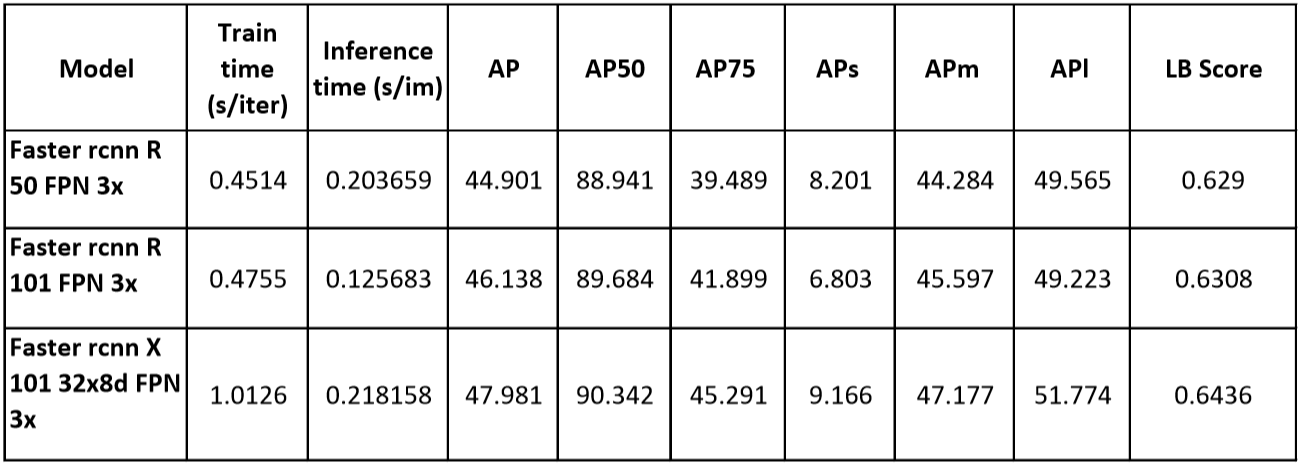

## With Augmentation

> Augmentation
> * RandomFlip Vertical (0.5)
> * RandomFlip Horizontal (0.5)
> * iter 5k & 10k

>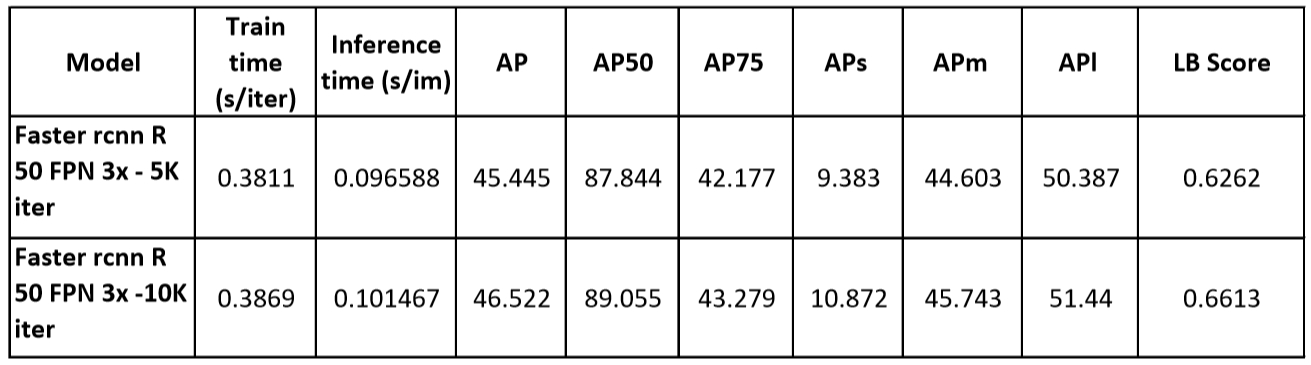

In [ ]:
df_sub = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')
df_sub

In [ ]:
# CONFIG

font = cv2.FONT_HERSHEY_SIMPLEX     
fontScale = 1 
color = (255, 255, 0)
thickness = 2
results = []

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)


def result_show(df, color):
    
    for image_id in df_sub['image_id']:
        im = cv2.imread('{}/{}.jpg'.format(TEST_DIR, image_id))
        boxes = []
        scores = []
        labels = []
        outputs = predictor(im)
        out = outputs["instances"].to("cpu")
        scores = out.get_fields()['scores'].numpy()
        boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
        labels= out.get_fields()['scores'].numpy()
        boxes = boxes.astype(int)
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        result = {'image_id': image_id,'PredictionString': format_prediction_string(boxes, scores)}
        results.append(result)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32)
        im /= 255.0
        
        for b,s in zip(boxes,scores):
            cv2.rectangle(im, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), color, thickness)
            cv2.putText(im, '{:.2}'.format(s), (b[0],b[1]), font, 1, color, thickness)
                
        plt.figure(figsize=(12,12))
        plt.imshow(im)

## Model 1

> - faster_rcnn_R_50_FPN_3x
> - Iter 5000

In [ ]:
result_show(df_sub['image_id'], color = (255, 255, 255))

## Model 2

> - faster_rcnn_R_50_FPN_3x
> - Iter 5000
> - RandomFlip Vertical (0.5)
> - RandomFlip Horizontal (0.5)

In [ ]:
result_show(df_sub['image_id'], color = (255, 255, 0))

## Model 3

> - faster_rcnn_R_50_FPN_3x
> - Iter 10000
> - RandomFlip Vertical (0.5)
> - RandomFlip Horizontal (0.5)

In [ ]:
result_show(df_sub['image_id'], color = (255, 0, 0))

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df

<h3><center>Thank you for reading my notebook, upvote if you like this notebook    :)<h3><center>
    
****

## References


* https://github.com/facebookresearch/detectron2

* https://www.kaggle.com/dhiiyaur/pytorch-fasterrcnn-eda-augmentation-training
    
* https://www.kaggle.com/orkatz2/inference-detectron2-resnest